# Preparacion de datos

* Nuestra primera tarea sera la de integracion de datos.

En un principio se necesitaba integrar la data de **ieee-github** pero esta ya se encontraba integrada en la data de Kaggle, por lo cual si la usabamos ocasionaria datos duplicados o posibles problemas si esta se usaba para la validacion u otras.

* **iee-github** queda descartado por la **Fase de Compresion de los datos**

##### Observacion:
* Los datos de kaggle en su mayoria ya son datos procesados, en nuestro caso debido a que la mayoria son imagenes medicas, se estima que hayan pasado por un **Algoritmo de segmentacion de imagenes medicas** es posibles que hayan pasado por **U-Net** un algoritmo de inteligencia artificial encargado de dicha segmentacion.

Las imagenes ya estan procesadas de manera en que tienen dimensiones de 256x256 pixeles

In [1]:
#realizamos algunas importaciones de datos
import matplotlib.pyplot as plt
import random
import seaborn as sns; sns.set()
import os
#desarrollamos una funcion para automatizar la muestra de imagenes por condicion de entrada

def show_xrays(path=None,size_img=(3,3),target=None):
    fig,axes=plt.subplots(size_img[0],size_img[1])
    fig.set_size_inches(10,10)
    img_list=os.listdir(path)
    img_list=random.sample(img_list,size_img[0]*size_img[1])
    #plt.axis(False)
    for i,ax in enumerate(axes.flat):
        image=plt.imread(os.path.join(path,img_list[i]))
        ax.imshow(image,cmap="jet",interpolation="nearest")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(f"Imagen {target} -{i+1}")
    plt.show()

Visualizamos algunos datos de COVID-19.

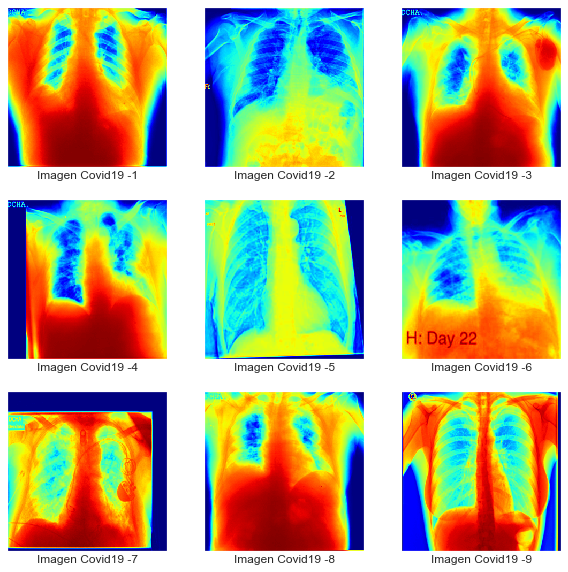

In [2]:
path_covid="../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID"
show_xrays(path_covid,target="Covid19")

* El **escalamiento y normalizacion de datos** se usara como un flujo de **Data Augmentation** durante el entrenamiento de datos

* El **balanceo de datos** se manejara con la implementacion de una funcion de perdida mejorada para penalizar las clases mayoritarias y dar una mejor prioridad a las clases minoritarias.

### Separación de los conjuntos de datos: Entrenamiento | Validacion | Prueba

* El entrenamiento usa el 70% de los datos.
* La validacion usa el 10%.
* La prueba usa el 20%. Este conjunto no se utiliza hasta que se desarrolle el algoritmo completo y funcional, sera una contrastacion con el mundo real.

In [3]:
#usaremos un script para automatizar el proceso de division de datos obteniendo la ruta de cada carpeta.
import pandas as pd
def generate_dataframe_datasets():
    list_target=["COVID","Lung_Opacity","Normal","Viral Pneumonia"]
    dataset={"PATH":[],"LABEL":[]}
    for target in list_target:
        path_general=f"../Datasets/KAGGLE_COVID-19_Radiography_Dataset/{target}"
        list_img=[arch.path for arch in os.scandir(path_general) if arch.is_file()]
        dataset["PATH"].extend(list_img)
        dataset["LABEL"].extend(len(list_img)*[target])
    
    return pd.DataFrame(dataset)

In [30]:
#generar el PATH con las UBICACIONES y LABEL 
data=generate_dataframe_datasets()

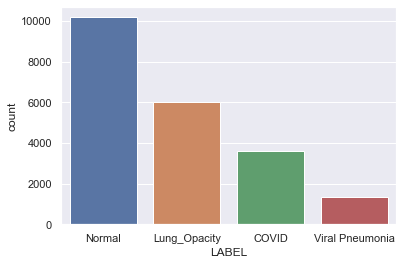

In [5]:
sns.countplot(x="LABEL",data=data,order=data.LABEL.value_counts().index)
plt.show()

Instanciamos la clase **train_test_split** para aprovechar la funcionalidad de division **stratify**

In [6]:
from sklearn.model_selection import train_test_split

train_data,test_data=train_test_split(data,random_state=42,test_size=0.2,shuffle=True,stratify=data.LABEL)
train_data,val_data=train_test_split(train_data,random_state=42,test_size=0.1,shuffle=True,stratify=train_data.LABEL)

In [7]:
#script para comparar la proporcion de clases para cada particion de datos
def plot_distribution_data(data,title=None,ax=None):
    if ax is None:
        fig,(ax)=plt.subplots(1,1)
    g=sns.countplot(x="LABEL",data=data,order=data.LABEL.value_counts().index,ax=ax)
   
    ax.set_title(title)

Mostramos como se dividieron los datos en modo grafico

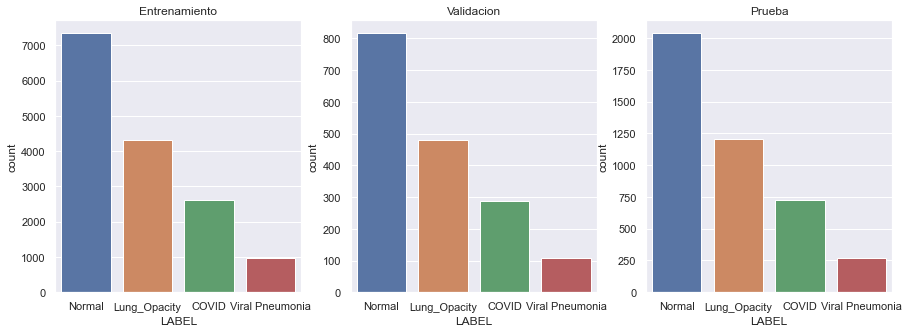

In [8]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3)
fig.set_size_inches(15,5)
plot_distribution_data(train_data,title="Entrenamiento",ax=ax1)
plot_distribution_data(val_data,title="Validacion",ax=ax2)
plot_distribution_data(test_data,title="Prueba",ax=ax3)

Se puede apreciar que hubo una buena division estratificada de datos. Esto es muy util en los problemas de clasificacion

#### PROPORCION DE LOS CONJUNTOS A SEPARAR

In [9]:
print("CONJUNTO DE ENTRENAMIENTO")
display(train_data.LABEL.value_counts(normalize=True,ascending=False).apply(lambda x:f"{x*100:0.2f}%"))
print("CONJUNTO DE VALIDACION")
display(val_data.LABEL.value_counts(normalize=True,ascending=False).apply(lambda x:f"{x*100:0.2f}%"))
print("CONJUNTO DE PRUEBA")
display(test_data.LABEL.value_counts(normalize=True,ascending=False).apply(lambda x:f"{x*100:0.2f}%"))

CONJUNTO DE ENTRENAMIENTO


Normal             48.16%
Lung_Opacity       28.40%
COVID              17.09%
Viral Pneumonia     6.35%
Name: LABEL, dtype: object

CONJUNTO DE VALIDACION


Normal             48.17%
Lung_Opacity       28.39%
COVID              17.06%
Viral Pneumonia     6.38%
Name: LABEL, dtype: object

CONJUNTO DE PRUEBA


Normal             48.15%
Lung_Opacity       28.42%
COVID              17.08%
Viral Pneumonia     6.35%
Name: LABEL, dtype: object

#### NUMERO DE ELEMENTOSxCLASE DE LOS CONJUNTOS A SEPARAR


In [10]:
print("CONJUNTO DE ENTRENAMIENTO")
display(train_data.LABEL.value_counts(ascending=False))
print("CONJUNTO DE VALIDACION")
display(val_data.LABEL.value_counts(ascending=False))
print("CONJUNTO DE PRUEBA")
display(test_data.LABEL.value_counts(ascending=False))

CONJUNTO DE ENTRENAMIENTO


Normal             7338
Lung_Opacity       4328
COVID              2604
Viral Pneumonia     968
Name: LABEL, dtype: int64

CONJUNTO DE VALIDACION


Normal             816
Lung_Opacity       481
COVID              289
Viral Pneumonia    108
Name: LABEL, dtype: int64

CONJUNTO DE PRUEBA


Normal             2038
Lung_Opacity       1203
COVID               723
Viral Pneumonia     269
Name: LABEL, dtype: int64

* Como es ideal, ahora los conjuntos que se dividiran tendran igual proporcion de clases, y eso evitara el sesgo en los datos, debido a que el modelo ahora vera la misma cantidad por igual.

Ahora desarrollamos el algoritmo de migracion de carpetas genericas a las destinadas train,val,test

In [24]:
import shutil
train_data.reset_index(drop=True,inplace=True)
val_data.reset_index(drop=True,inplace=True)
test_data.reset_index(drop=True,inplace=True)

def split_data_by_info(data_info=list(),dest_path="."):
    for tipo,df in data_info:
        ruta=os.path.join(dest_path,tipo)
        if not os.path.exists(ruta): #si no existe la ruta, entonces la crea
            os.mkdir(ruta) #crear ruta
            print(f"Directorio {tipo} CREADO")
        #recorrer todo el dataset de informacion de rutas
        for i in range(df.LABEL.count()):
            subdir_name=df.loc[i,"LABEL"]
            subdir_path=os.path.join(ruta,subdir_name) 
            if not os.path.exists(subdir_path): #si no existe entonces la crea
                os.mkdir(subdir_path)
                print(f"Subdirectorio {subdir_name} CREADO")
            ruta_img=df.loc[i,"PATH"]
            print(f"Moviendo {ruta_img} -> {subdir_path}")
            shutil.move(ruta_img,subdir_path)


In [25]:
data_info=[("train",train_data),("val",val_data),("test",test_data)]
dest_path="../Datasets/"


In [32]:
split_data_by_info(data_info,dest_path)

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2043.png -> ../Datasets/train\COVID
Subdirectorio Lung_Opacity CREADO
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2179.png -> ../Datasets/train\Lung_Opacity
Subdirectorio Normal CREADO
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-10142.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6206.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6183.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3327.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5690.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3544.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/N

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-1308.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5770.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3597.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2001.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-276.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3697.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2004.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5294.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_R

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3421.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-714.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4824.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6631.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4919.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1249.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2138.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-699.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lu

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7259.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5467.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4734.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-468.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2449.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1460.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-10179.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1971.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4471.

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4406.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8938.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6668.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4855.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1625.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3195.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4464.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-296.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1487.png

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4934.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-1239.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-1114.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3004.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-746.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7566.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-370.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3138.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-492.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3682.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3914.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-842.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3948.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1835.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8854.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7098.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1519.png -> ../Datasets/trai

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6903.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5860.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-895.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4543.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3721.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-954.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2182.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4588.png -> ../Datasets/train\Lung_Opacity
Moviendo ../

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1737.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3591.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4036.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1194.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1458.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1975.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1342.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1014.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7248.png -> ../Datasets/train\No

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-1289.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7411.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-85.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2223.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5883.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5678.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2301.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3194.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3156.png 

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-346.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3538.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5246.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2708.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1921.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1531.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2756.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6558.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3953.png -> ../Datasets/

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3609.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1602.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-669.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1921.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1380.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9755.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3411.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3286.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-637.pn

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-10078.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2646.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5228.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-325.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1282.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1723.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3606.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4213.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-129.png -> ../Datase

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2491.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1475.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5547.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3338.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2273.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-777.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-281.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6364.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5624.pn

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5225.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8137.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1490.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4891.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6659.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1426.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1430.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5321.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-36

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5640.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2504.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1598.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7635.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3530.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3833.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1271.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3162.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-631.p

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-84.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3197.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2286.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5185.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2847.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4783.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4083.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4977.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3084.pn

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-718.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2512.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6294.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1201.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5183.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2115.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4712.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8316.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1763.png -> ../Datasets/tra

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4048.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4748.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5474.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2978.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-724.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4098.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-398.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6636.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1783.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3070.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3313.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8087.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3538.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-10174.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-1022.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-240.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3483

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2401.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2436.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4603.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2364.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9282.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6339.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2067.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-557.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-290.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7107.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7968.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1255.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-664.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8745.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-171.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4994.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-949.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5124.png -> ../Datasets/tr

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-866.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1656.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-125.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1948.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5625.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-417.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5471.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-928.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVI

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1575.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4735.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9979.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-244.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-217.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1888.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1123.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8723.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8309.png -> ../Datasets/train\Norm

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3081.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5909.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1075.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5045.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-13.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3455.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-581.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4067.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-875.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7036.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-10188.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2016.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2176.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9366.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4082.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1279.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8544.png -> ../Datasets/train\Normal
Moviendo ../Data

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7214.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8255.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-1205.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4554.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1929.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2673.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9013.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-381.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\CO

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4932.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8641.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1873.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2103.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-562.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-479.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2604.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-797.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1406.png -> ../Dataset

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9442.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-445.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6865.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6725.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3516.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5396.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4357.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6986.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-162.png -> ../Datasets/train\COVID
Moviendo ../Datase

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8476.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1013.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-588.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-835.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8208.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8672.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2358.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2864.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6706.png -> ../Datasets/train\Normal
Moviendo ../Dat

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9050.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-579.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8446.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-516.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-501.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-822.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1435.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5012.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2033.png -> 

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2965.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3830.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1696.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5323.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8789.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-887.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2972.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5123.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7045.p

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2913.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-306.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5220.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-271.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4943.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5080.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6591.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4043.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7585.png -> ../Datasets/train\Normal
Mov

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1468.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5319.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8558.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2395.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4361.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1155.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5481.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8486.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3149.png -> ../Datas

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2087.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2270.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1045.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-761.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6482.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3212.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5709.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1287.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-11

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6255.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5799.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4802.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1786.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1260.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1809.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2223.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1095.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1044.png -> ../D

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-361.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-315.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-1002.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-186.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4453.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-464.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1550.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-293.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5843.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5156.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-49.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7609.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-117.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2095.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1836.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6603.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Rad

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1268.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1439.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2655.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4303.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2937.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3901.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2498.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7850.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1771.png -> ../Data

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1187.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8155.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4390.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8461.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2961.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5327.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-232.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1113.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2394.png -> ../Datasets/train\Lung_Opacity
Movie

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6226.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1456.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2264.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2574.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1840.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-538.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5044.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3035.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3169.png -> ../Datasets/train\COVID
Moviendo ../Datas

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2475.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3817.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-762.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-128.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1765.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2425.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2553.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2915.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-1179.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2140.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-214.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5026.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2568.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5802.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2119.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7310.png -> ../Datasets/train\Normal
Mo

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5745.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-197.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4992.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3172.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2683.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3272.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9276.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-890.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-994.png -> ../Datasets/train\Normal
Movi

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1546.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-745.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4078.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3801.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4960.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3666.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4748.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9811.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiograph

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6964.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3501.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3613.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-732.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2462.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1544.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3549.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7726.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6037.png -> ../Datase

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3678.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-998.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-812.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4569.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4536.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7797.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8968.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2854.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9019.png -> ../Datasets/train\Norm

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3145.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-584.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4510.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2882.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3685.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5816.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6696.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2427.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radi

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8821.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4114.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-10068.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4109.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2725.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-631.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1103.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5849.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-834.p

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-915.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2677.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8611.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-241.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9279.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-844.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-732.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2119.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiogr

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6700.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1956.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2717.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3054.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8478.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3915.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1649.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-12.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1035.png -> ../Datase

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6527.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1424.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4341.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2870.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-700.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2238.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4331.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1665.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-956.png -> ../Dataset

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6137.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1481.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7308.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6961.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3637.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3640.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-165.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2990.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1596.png -> ../Datasets/train\Nor

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9408.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-553.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2589.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3425.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1337.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6789.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1703.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3824.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3402.png -> ../Datasets/train\COVID
Mo

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1770.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2430.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9193.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8896.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-584.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-434.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-947.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-337.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1227.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KA

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-62.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7643.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-380.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9620.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5573.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9180.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2480.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6435.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4145.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5532.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-876.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-226.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9270.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5323.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7168.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5551.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3827.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6983.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5651.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4946.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4146.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1484.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-249.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3536.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-535.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7811.png -

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-621.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8764.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-938.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5159.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2546.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5811.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5698.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1063.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-695.png

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1727.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3374.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9615.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-574.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-10168.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-415.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5194.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7068.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacit

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4945.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-506.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2517.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9589.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1317.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7588.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-269.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7703.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9372.png -> ../Datasets/train\Normal
Moviendo 

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1108.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6625.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1473.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4820.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3157.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5210.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5124.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9901.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4083.png -> ../Datasets/train\Normal
Moviendo ../Data

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5632.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7002.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7846.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-250.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9827.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3632.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-526.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1415.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Nor

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8669.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1807.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6066.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9085.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7395.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-805.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3297.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-807.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3600.png -> ../Datasets/train\COV

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2664.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-522.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3067.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3672.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7401.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3072.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3851.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7591.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_R

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1387.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3322.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-646.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5373.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5941.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3074.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4662.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-531.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4447.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5760.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9460.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6180.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7170.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1657.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3230.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1698.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2951.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1659.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-931.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6048.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-223.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2106.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-384.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9436.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5945.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Rad

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2619.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-679.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-715.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4956.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9464.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-502.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1581.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6477.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COV

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3000.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9059.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-6000.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-368.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3957.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1362.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1376.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5931.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8064.png -> ../Datasets/train\Normal
Moviendo ../Datas

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-1147.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2716.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2526.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7129.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-748.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4217.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-58.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1968.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5684.

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-681.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-606.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5087.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2616.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6743.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5144.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3501.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-266.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2843.png -> ../Datasets

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2358.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5979.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2381.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-268.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7878.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5838.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4548.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8511.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2354.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3504.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-852.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2152.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7540.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3718.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3291.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9287.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-935.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-375.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-789.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2668.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2567.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-673.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1765.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5751.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2999.png -> ../Datasets/tr

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4873.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-155.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-848.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2479.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-651.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5539.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3913.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2147.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4237.png -> ../Datasets

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6133.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1786.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2955.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1025.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2650.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8276.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8687.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2802.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6.png -> ../Datasets/train\Normal
Moviendo ../Dataset

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-608.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-729.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2181.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6076.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2724.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7626.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5253.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2954.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3278.png -> ../Dataset

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3217.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-633.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6712.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4928.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-30.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3087.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1125.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1278.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3014.png -> ../Datasets/train\Normal
Movi

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5852.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8747.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7019.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-840.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1498.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1310.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-539.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5440.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9105.png -> ../Datasets/trai

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-261.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9885.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6278.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2671.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-287.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1978.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8618.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-323.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/C

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-568.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3002.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8870.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3133.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5377.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5799.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3639.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3227.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumon

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2980.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3750.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1097.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2723.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5198.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3372.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5212.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2826.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Nor

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5189.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1934.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3150.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3968.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4480.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5711.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-144.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2511.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-147.png -> ../Datasets/train\COVID


Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-760.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2029.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8905.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5750.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4513.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-449.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7410.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6523.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6765.png -> ../D

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5754.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3535.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7351.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1204.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4552.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2976.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8664.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-122.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3820.png -> ../

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-753.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1488.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2786.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4225.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1676.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-10150.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5750.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4127.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9744.png -> ../Datasets/train\Norma

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3237.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-45.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5590.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8769.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9472.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3757.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-10093.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-668.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3248.png -> .

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4339.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2630.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4112.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1017.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3481.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2013.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3037.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5325.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1451.png -> ..

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-386.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1056.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2298.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1843.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8738.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1047.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9618.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-275.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-345.png -> ../Datasets/t

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-1069.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-963.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5089.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9646.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2216.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-141.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-627.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-234.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVI

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-1109.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1970.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1711.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1836.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-336.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3497.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4123.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7015.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3001.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8967.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2837.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9342.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3341.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1051.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-6010.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3841.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2775.png -> ../Datas

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-770.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6009.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2679.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2344.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1029.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-236.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4189.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1768.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1647.png -> ../Dat

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7444.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4380.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6174.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5280.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3285.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1320.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3662.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-535.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5276.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-1

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2596.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-411.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8970.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4671.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-943.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1281.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-398.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4170.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiograp

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-860.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-319.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2739.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1439.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2959.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-609.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1637.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-419.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2097.png -> 

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-769.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2754.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4188.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5755.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1379.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-443.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5032.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4935.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacit

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3822.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-961.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5392.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3040.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1334.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-866.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3106.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5294.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5001.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2177.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2163.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5851.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3240.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3594.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-1012.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4898.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiog

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2086.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1219.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8026.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-468.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3568.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2878.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4922.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-441.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6100.png -> ../Data

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-156.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1888.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1868.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9029.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2860.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8343.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-4.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2339.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5707.png 

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3189.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4370.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-372.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5772.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4026.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3108.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1670.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3859.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7745.png -> ../Datasets/train\Normal
Moviendo ../Datas

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8913.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3147.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-198.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-306.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-742.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7986.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4383.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5091.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVI

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3165.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-90.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2336.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-16.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1190.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2532.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-771.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3688.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_CO

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2550.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-197.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4910.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3841.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-255.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6513.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9825.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3282.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2150.png -> ../Datasets/train\COVID
Moviendo ../Datasets/

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4138.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9444.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5027.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-388.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4336.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1448.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2687.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1124.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6966.png -> ../Datasets/train\Nor

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2035.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5263.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-114.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4666.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1591.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-234.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-131.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5802.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9335.png -> ../Datas

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2791.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4070.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2964.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3059.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-733.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9530.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2286.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5477.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-10149.png -> ../Datasets/train\No

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8332.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5755.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8482.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-602.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-903.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-870.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-6011.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2125.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/C

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2007.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2041.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7235.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7890.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-318.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8158.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2161.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-6.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7306.png -> ../Datasets/train\Normal
Moviendo

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2812.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1898.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2901.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8259.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2578.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2597.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5373.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3938.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1646.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5803.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1745.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4546.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9421.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-672.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-656.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1117.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3312.png -> ../Datasets/train\COVID
Moviendo ../Dat

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2984.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3493.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9794.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9621.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1795.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2324.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-63.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1563.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1928.png -> ../Datasets/

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5412.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9920.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-387.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5743.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2175.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9046.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-402.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7143.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\No

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-1131.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5903.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2412.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-876.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2487.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8364.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1391.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7317.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-171

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2482.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4551.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3389.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3940.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-483.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5105.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3888.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1246.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1842.png -> ../

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6624.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7775.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3922.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7218.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1093.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-863.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2949.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6310.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4143.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-229.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2942.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-190.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2335.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2831.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2307.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-1050.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3111.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-10089.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4347.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6192.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2492.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1573.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1798.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5709.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-77.png -> ../Datasets/train\COVID

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9936.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1881.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3821.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-851.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2257.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7065.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3229.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4166.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6753.png -> ../Dat

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4159.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6087.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1370.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3128.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3868.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-167.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4145.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1699.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\L

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1954.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5388.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3109.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3356.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4794.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5248.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3405.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-351.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4598.p

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4857.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-654.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1177.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7927.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-466.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-605.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7756.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1348.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/L

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1280.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2955.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-379.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-749.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8932.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2475.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8793.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8572.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2815.pn

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2178.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5110.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2373.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1207.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2600.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1304.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3166.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8082.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3574.png -> ../Datasets/train\COVID
Moviend

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3251.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5375.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2040.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2180.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4766.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4242.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-27.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3679.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lun

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5672.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5053.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1832.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2357.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-791.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-520.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9033.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4885.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-10107.png -> ../Datasets/train\Nor

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-10100.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8890.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9058.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8489.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2888.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2088.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5257.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8782.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9458.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1923.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2631.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4469.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3785.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3635.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4473.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8412.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-140.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacit

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7788.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3574.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-943.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4965.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1535.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7557.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3772.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2551.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7272.png -> ../Datasets/train\Normal
Moviendo ../Da

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-9.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8420.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-683.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6184.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-1149.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-952.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4204.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4543.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Datas

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1704.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2111.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-632.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4951.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-881.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4751.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7473.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3328.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6909.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7520.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4481.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1156.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4424.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-682.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1707.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2704.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9381.png -> ../Dat

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7648.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7027.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5775.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-1016.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2786.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8370.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-63.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-911.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiog

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-612.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2220.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3108.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1621.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3943.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-128.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-850.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2156.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9874.png -> ../Datasets

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4836.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5637.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7425.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-375.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4432.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9806.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5142.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1418.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3858.png -> 

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1243.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3719.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4605.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1612.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-8.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1444.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3312.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-708.png -> ../Datasets/train\COVID
Moviendo ../Datas

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-235.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3034.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4461.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8115.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8262.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5492.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-783.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1417.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-591.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7541.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5768.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-1294.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4431.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1483.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-974.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9015.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radio

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5664.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2296.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-249.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2933.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5517.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9304.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2536.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2362.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6047.png -> ../Datasets/tra

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2470.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1966.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1276.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4315.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2508.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1503.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1251.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8957.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3481.png -> ../D

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2885.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-159.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4378.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1621.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-682.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1436.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-231.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5376.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1919.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5099.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-216.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-138.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5477.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5484.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-494.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2266.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3772.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-10075.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-850.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2492.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-328.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1346.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-100.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4161.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-630.png -> ../Data

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1004.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8530.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2607.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3800.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4351.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-157.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4581.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1159.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9639.png -> ../Datasets/train\Nor

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5149.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3025.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-517.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4548.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5125.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2851.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-1040.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4450.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_R

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7640.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4314.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9562.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8393.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6893.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5059.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4539.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1166.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-830.png -> ../Datasets/train\CO

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-160.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8227.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7447.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3856.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-107.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-560.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5931.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-230.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4470.png -> ../Datase

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2390.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-638.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2586.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5405.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-564.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-896.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3291.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2254.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Nor

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1081.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7900.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2270.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3834.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1550.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1627.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-847.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1280.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4610.png -> ../Datasets/tra

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2129.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2607.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2594.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-713.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4815.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1336.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-940.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2289.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-865.png -> ../Datasets/trai

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1777.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2906.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3025.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1767.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5850.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1561.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3961.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1183.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1809.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3082.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-818.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-497.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2577.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-173.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3043.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1922.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5497.png -> ../Datasets/train\Norma

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3655.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-256.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2911.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6737.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9214.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1581.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-10012.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1816.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5450.png -> ../Da

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5752.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2606.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5815.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-582.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-96.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5785.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-979.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-401.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-326.png -> ../D

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5343.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1711.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-415.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-627.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2338.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3240.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1414.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5885.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1945.png -> ../Datasets/t

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-251.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2585.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5869.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3095.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8750.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3743.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2263.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4533.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3514.p

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4918.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2213.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4783.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1384.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-364.png -> ../Datasets/train\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7377.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-235.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5704.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiogra

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5990.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1498.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5107.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6597.png -> ../Datasets/train\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4741.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2529.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3204.png -> ../Datasets/train\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1408.png -> ../Datasets/train\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4640.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1235.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-931.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1349.png -> ../Datasets/val\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8974.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3181.png -> ../Datasets/val\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4599.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5435.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumoni

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3458.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4505.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3686.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1497.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-774.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2715.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-436.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5588.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8269.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_CO

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3488.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1378.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1920.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2752.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-698.png -> ../Datasets/val\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7123.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1364.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7274.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-1247.png -> ../Data

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5103.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-960.png -> ../Datasets/val\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6861.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3017.png -> ../Datasets/val\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2211.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-958.png -> ../Datasets/val\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7342.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2417.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-276.png -> ../Datasets/val\Normal
Moviendo .

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-550.png -> ../Datasets/val\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9286.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9498.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6955.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1698.png -> ../Datasets/val\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-36.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-945.png -> ../Datasets/val\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-1207.png -> ../Datasets/val\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-231.png

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2416.png -> ../Datasets/val\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-830.png -> ../Datasets/val\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4297.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1974.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3829.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7063.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5369.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1227.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-967.png -> ../Datasets/val\Viral Pneumon

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1391.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1556.png -> ../Datasets/val\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1774.png -> ../Datasets/val\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3117.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2833.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5162.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1592.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-628.png -> ../Datasets/val\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1000.png -> ../Datasets/val\Lung_Opacity
Moviendo

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-496.png -> ../Datasets/val\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7159.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-664.png -> ../Datasets/val\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-476.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4260.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4787.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6885.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1613.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lu

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2552.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2181.png -> ../Datasets/val\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5285.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7954.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1831.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2253.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3807.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3102.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5454.png -> ../Datasets/val\No

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3069.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6290.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7476.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6947.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2432.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2310.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1783.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8578.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1188.png -> ../Datasets/val\COVID
Moviendo ../D

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6586.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9319.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4211.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5133.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5500.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3269.png -> ../Datasets/val\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-184.png -> ../Datasets/val\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4344.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6778.png -> ../Datasets/val\Normal
Moviendo ../Datas

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8718.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3432.png -> ../Datasets/val\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4869.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5448.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-48.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2801.png -> ../Datasets/val\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3329.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3399.png -> ../Datasets/val\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3895.png -> ../Datasets/va

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5493.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6210.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3238.png -> ../Datasets/val\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3572.png -> ../Datasets/val\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2782.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7592.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5933.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-170.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-154.png -> ../Da

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8712.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1667.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5813.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-898.png -> ../Datasets/val\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-7.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1673.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4028.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-719.png -> ../Datasets/val\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-674.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3920.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-831.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5260.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1618.png -> ../Datasets/val\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-41.png -> ../Datasets/val\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2641.png -> ../Datasets/val\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5226.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3085.png -> ../Datasets/val\COVID
Moviendo

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-164.png -> ../Datasets/val\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2463.png -> ../Datasets/val\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7419.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8504.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9574.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1479.png -> ../Datasets/val\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4239.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1717.png -> ../Datasets/val\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2239.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_R

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7167.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5047.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4501.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-307.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-739.png -> ../Datasets/val\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1839.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7826.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1261.png -> ../Datasets/val\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5723.png -> ../Datasets/val\Normal
Moviendo ../Datasets/KAG

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1989.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-481.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7597.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-130.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5241.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8744.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1491.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4059.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3929.png -> 

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4415.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-865.png -> ../Datasets/test\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4279.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4839.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-736.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1486.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6930.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3092.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_D

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-562.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2761.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1831.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1364.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5499.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-532.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2009.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6864.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1640.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_CO

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3289.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3543.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5686.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8347.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-343.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5029.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-967.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5810.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opaci

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3584.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1106.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5402.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3026.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-238.png -> ../Datasets/test\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5096.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3509.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2944.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVI

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8835.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3509.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9880.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7407.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5040.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2978.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8909.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-993.png -> ../Datasets/test\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5417.png -> ../Datas

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4661.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3422.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8910.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4084.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3295.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3667.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1330.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5034.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3567.png -> ../Datasets/test\Normal
Moviend

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1744.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-660.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2048.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2150.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2146.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2890.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5322.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5467.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-513.png -> ../Datasets/test\Lung_Opaci

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4551.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-10184.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1368.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-352.png -> ../Datasets/test\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3130.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2309.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5014.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-186.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opaci

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1505.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3039.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-947.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1346.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1553.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9149.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8815.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3071.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7119.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVI

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7042.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-894.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3473.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-509.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4695.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2695.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3339.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-63.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2840.png -> ../Datasets/te

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2325.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-618.png -> ../Datasets/test\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6362.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2886.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-929.png -> ../Datasets/test\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2496.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7971.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8953.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/No

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4929.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3307.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9699.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3142.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1247.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1511.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4483.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3722.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2023.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5358.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4305.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8007.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5668.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1982.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-133.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1242.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5047.png ->

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3408.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2429.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2224.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3411.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-888.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-10164.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5475.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-446.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3891.png -> ../Datasets/test\Normal
Moviendo

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3308.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-327.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-798.png -> ../Datasets/test\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-24.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4533.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7188.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7497.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3907.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6029.png -> ../Da

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3208.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-4.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1496.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-53.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-428.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4775.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2458.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-680.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3375.png -> ../Datasets/test\COVID
Moviendo ../Datasets

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7468.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1467.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4754.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8663.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4743.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-507.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9132.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4888.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-15

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5858.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9939.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6117.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4432.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2259.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-291.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-52.png -> ../Datasets/test\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7792.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3219.png -> ../Datasets/test\Lung_Opacit

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1169.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-119.png -> ../Datasets/test\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3516.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4792.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4635.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1133.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-765.png -> ../Datasets/test\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2958.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radi

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1605.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1606.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9377.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4251.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7872.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-83.png -> ../Datasets/test\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3650.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3431.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9090.png -> ../Dat

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3486.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9292.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4217.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9592.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2951.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2378.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-118.png -> ../Datasets/test\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5233.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5320.png -> ../Datasets/test\Nor

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1636.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2686.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4605.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3432.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3110.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5819.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-545.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2581.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opac

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1957.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8319.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6967.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-361.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2943.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1979.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2692.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1142.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1212.png -> ../Datasets/test\Lung_Opacity
Moviendo ..

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-900.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2889.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1915.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5175.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6632.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5536.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2602.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6170.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5621.png -> ../Datasets/test\Normal
Moviendo ../Datasets

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3945.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1535.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4298.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1003.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3192.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2631.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4698.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4561.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-902.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4392.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2722.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2022.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2064.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2528.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3345.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9961.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-1280.

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-367.png -> ../Datasets/test\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3529.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8720.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5766.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-959.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3915.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-663.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2778.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2719.pn

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3103.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2859.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1140.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-1072.png -> ../Datasets/test\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-1111.png -> ../Datasets/test\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1463.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-137.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2645.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/L

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1120.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-70.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1226.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3565.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6136.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3386.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2787.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7361.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1207.png -> ../Datasets/test\Lung_Opacity
Moviendo 

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6484.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3845.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-361.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1115.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1213.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5998.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-435.png -> ../Datasets/test\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2406.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8604.png -> ../Dat

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2193.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1782.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9775.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6654.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2594.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4591.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2362.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5879.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6046.png -> ../Datasets/test\Normal
Moviend

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5423.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1371.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-681.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5967.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2351.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-982.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-496.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1622.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-32.png 

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1437.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4136.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-813.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2670.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1351.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3485.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2575.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1658.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-778.png -> ../

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5606.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-555.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9401.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-498.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5009.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2867.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3741.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9353.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3206.png -> ../Datase

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6311.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-6012.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5197.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4588.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-833.png -> ../Datasets/test\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4205.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3956.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-56

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1625.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-10059.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2063.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5798.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7930.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-1255.png -> ../Datasets/test\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3522.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6050.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4780.png -> 

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9789.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-360.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1299.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-3235.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1611.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-185.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-4704.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1236.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-637.png -> ../Datasets/test

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-2731.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2602.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9188.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-756.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1464.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-890.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7687.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3499.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5476.png -> ../Datasets/test\Normal
Moviendo 

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4438.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-552.png -> ../Datasets/test\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-429.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2403.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6971.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-1344.png -> ../Datasets/test\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7314.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1815.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-817

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-939.png -> ../Datasets/test\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-3369.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3883.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5446.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2225.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1797.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1467.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5078.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3175.png -> ../Datasets/test\

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9579.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-478.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-496.png -> ../Datasets/test\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-5661.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-551.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9322.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2726.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2624.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-10088.png -> ../Datasets/test\Normal


Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1628.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2580.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Viral Pneumonia\Viral Pneumonia-885.png -> ../Datasets/test\Viral Pneumonia
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-1374.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4968.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5641.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-705.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8610.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-10136.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8371.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5642.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-4106.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-7587.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-1720.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\Lung_Opacity-5239.png -> ../Datasets/test\Lung_Opacity
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-3910.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Lung_Opacity\L

Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-6617.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/COVID\COVID-2166.png -> ../Datasets/test\COVID
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-1792.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-8992.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-9190.png -> ../Datasets/test\Normal
Moviendo ../Datasets/KAGGLE_COVID-19_Radiography_Dataset/Normal\Normal-2103.png -> ../Datasets/test\Normal


* La separacion de datos esta lista. Ahora nos vamos a la fase de modelado